In [4]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [5]:
# imports 
import torch
import pandas as pd

from src.baseline.vocabulary import Vocabulary
from src.baseline.data_loader import get_loader, get_mean, get_std
from src.baseline.coa_model import get_new_model, init_testing_model,test_model,test_rand_image

In [7]:
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold=1)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


## Evaluate a vanilla model on the real data

In [13]:
# REAL_DATASET='/home/salnabulsi/coat-of-arms/data/cropped_coas/out'
REAL_DATASET='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out'
test_annotation_psumsq_file  = REAL_DATASET + '/test_real_captions_psumsq.txt'
data_location = REAL_DATASET + '/images/resized'

In [14]:
#Hyperparams
embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0
batch_size = 125
NUM_WORKER = 2
freq_threshold = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }
pretrained = False
model, optimizer, criterion = get_new_model(hyper_params, learning_rate, ignored_idx, drop_prob, device, pretrained)


In [17]:
mean=0.3272075951099396
std=0.3805903494358063
#09-baseline-model-test

In [18]:

test_loader, test_dataset = init_testing_model(test_annotation_psumsq_file, data_location, 
                                               mean, std,
                                               NUM_WORKER,vocab, batch_size, 
                                               device, pin_memory=False,
                                               img_h=620, img_w=600)


In [19]:

test_model(model, criterion,test_loader, test_dataset, vocab_size, device, 'vanilla-logs', True) 


No shield color found in this label: "8 1 1 1 & & & & 7 7 & & & & & & & & &"
Test Acuuracy (in progress): 0.000000

label "8 1 <UNK> 1 1 1 7 7 7 7 & & & & & & & & &" cannot be parsed. The chunk "<UNK>" cannot be fit into any category.
No shield color found in this label: "8 1 <UNK> 1 1 1 7 7 7 7 & & & & & & & & &"
Test Acuuracy (in progress): 0.000000

label "8 1 1 1 1 1 1 <UNK> patonce patonce & & & & & & & & &" cannot be parsed. The chunk "<UNK>" cannot be fit into any category.
No shield color found in this label: "8 1 1 1 1 1 1 <UNK> patonce patonce & & & & & & & & &"
Caption Class - exception in label 8 1 1 1 1 1 1 <UNK> patonce patonce & & & & & & & & &, ['<UNK>', 'patonce']
Test Acuuracy (in progress): 0.000000

Test Loss (final): 0.041098

Test Accuracy (Overall): 0.0%


([tensor(3.7020), tensor(3.6870), tensor(3.6664)],
 [0.0, 0.0, 0.0],
 0.0,
 tensor(0.0411))

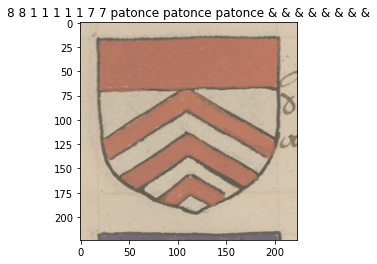

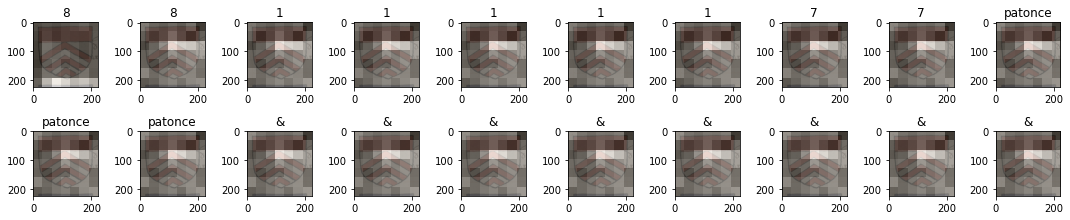

In [21]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)

## Evaluate a vanilla model on the synthetic test data


In [22]:
data_location =  '../baseline-gen-data/large'
root_folder_images = data_location + '/images'
test_psumsq_file = data_location + '/test_captions_psumsq.txt'
df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

NameError: name 'test_caption_file' is not defined

In [24]:
#Hyperparams
embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0
batch_size = 125
NUM_WORKER = 2
freq_threshold = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }
pretrained = False
model, optimizer, criterion = get_new_model(hyper_params, learning_rate, ignored_idx, drop_prob, device, pretrained)


In [27]:
test_loader, test_dataset = init_testing_model(test_psumsq_file, root_folder_images, 
                                               mean, std,
                                               NUM_WORKER,vocab,batch_size, 
                                               device, pin_memory=False,
                                               img_h=500, img_w=500)


In [29]:
test_model(model, criterion,test_loader, test_dataset, vocab_size, device, 'vanilla-logs', real_data=False) 

No shield color found in this label: "10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10"
Test Acuuracy (in progress): 0.000000

No shield color found in this label: "10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10"
Test Acuuracy (in progress): 0.000000

label "10 10 10 10 10 10 10 <PAD> 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> rampant" cannot be parsed. The chunk "<PAD>" cannot be fit into any category.
label "10 10 10 10 10 10 10 <PAD> 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> rampant" cannot be parsed. The chunk "<PAD>" cannot be fit into any category.
label "10 10 10 10 10 10 10 <PAD> 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> rampant" cannot be parsed. The chunk "<PAD>" cannot be fit into any category.
label "10 10 10 10 10 10 10 <PAD> 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> rampant" cannot be parsed. The chunk "<PAD>" cannot be fit into any category.
label "10 10 10 10 10 10 10 <PAD> 10 <PAD> <PAD> <PAD>

([tensor(3.6352), tensor(3.6482), tensor(3.6468), tensor(3.6505)],
 [0.0, 0.0, 0.0, 0.0],
 0.0,
 tensor(0.0365))

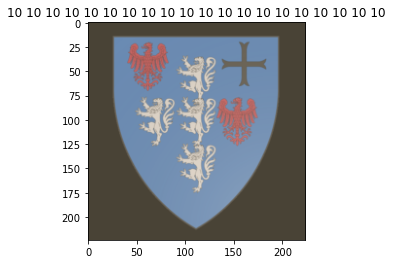

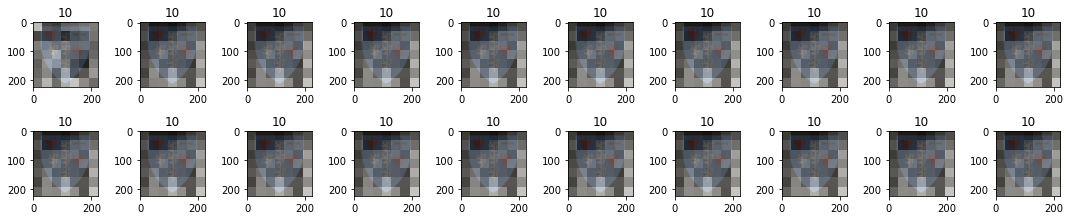

In [ ]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)